# Sistem Rekomendasi Makanan Menggunakan Hybrid-Based Filtering
# 1. Pendahuluan

Notebook ini berisi implementasi sistem rekomendasi makanan menggunakan pendekatan Hybrid-Based Filtering. Pendekatan ini bekerja dengan cara merekomendasikan makanan yang memiliki kemiripan konten dengan makanan yang telah dibaca pengguna. Dataset diambil dari Kaggle: https://www.kaggle.com/datasets/schemersays/food-recommendation-system

# 2. Import Library
Melakukan Import Library yang dibutuhkan untuk analisis data, visualisasi, pemrosesan teks, dan modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3. Data Preparation
Tahapan ini berjuan untuk memuat dataset, menggabungkan kedua dataset, setelah itu mencari missing values, duplikat untuk dibersihkan

## Load Dataset
Memuat Dataset ke dataframes pandas `food_df` & `ratings_df`
1. food_df terdiri dari:
* Food_ID
* Name
* C_Type
* Veg_Non
* Describe

2. rating_df terdiri dari:
* User_ID
* Food_ID
* Rating



In [3]:
# Load datasets
ratings_df = pd.read_csv("ratings.csv")
food_df = pd.read_csv("food.csv")

## Menangani Missing Values
Mencari dan Menangani Missing Values pada dataframe `rating_df` & `food_df`

In [4]:
# ratings_df
drop_ratings_df = ratings_df.dropna()
print(drop_ratings_df.isna().sum())

User_ID    0
Food_ID    0
Rating     0
dtype: int64


In [5]:
# food_df
print(food_df.isna().sum())

Food_ID     0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64


## Menangani Duplikat
Mencari apakah ada duplikasi dan Menghapus Duplikasi pada `food_df` & `ratings_df` bila ada

In [6]:
# food_df
print(food_df.duplicated().sum())

0


In [7]:
# ratings_df
print(ratings_df.duplicated().sum())

0


# 4. Explatory Data Analysis (EDA)
Tahapan ini bertujuan untuk mencari statistik deskriptif makanan, mencari makanan terpopuler, mencari distribusi ratings

## Informasi Data
Melihat Informasi Tipe Data pada Dataframe
`food_df` & `ratings_df`

In [8]:
# food_df
print("\nInfo dataset makanan:")
print(food_df.info())

#ratings_df
print("\nInfo dataset ratings:")
print(ratings_df.info())


Info dataset makanan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None

Info dataset ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB
None


## Statistik Deskriptif

In [28]:
# Statistik Deskriptif food_df
print("\nStatistik deskriptif:")
print(food_df.describe(include='all'))

# Statistik Deskriptif ratings_df
print("\nStatistik deskriptif:")
print(ratings_df.describe(include='all'))


Statistik deskriptif:
           Food_ID                   Name  C_Type Veg_Non    Describe  \
count   400.000000                    400     400     400         400   
unique         NaN                    396      15       2         396   
top            NaN  lemon poppy seed cake  indian     veg  riety rice   
freq           NaN                      2      88     238           3   
mean    200.500000                    NaN     NaN     NaN         NaN   
std     115.614301                    NaN     NaN     NaN         NaN   
min       1.000000                    NaN     NaN     NaN         NaN   
25%     100.750000                    NaN     NaN     NaN         NaN   
50%     200.500000                    NaN     NaN     NaN         NaN   
75%     300.250000                    NaN     NaN     NaN         NaN   
max     400.000000                    NaN     NaN     NaN         NaN   

                                                 combined  
count                                   

## Visualiasi Makanan Populer
Melakukan Visualisasi Untuk Mencari Makanan Populer

Berdasarkan Grafik, Makanan Paling Populer Adalah :

1. Indian.

2. Healthy Food.

3. Dessert.

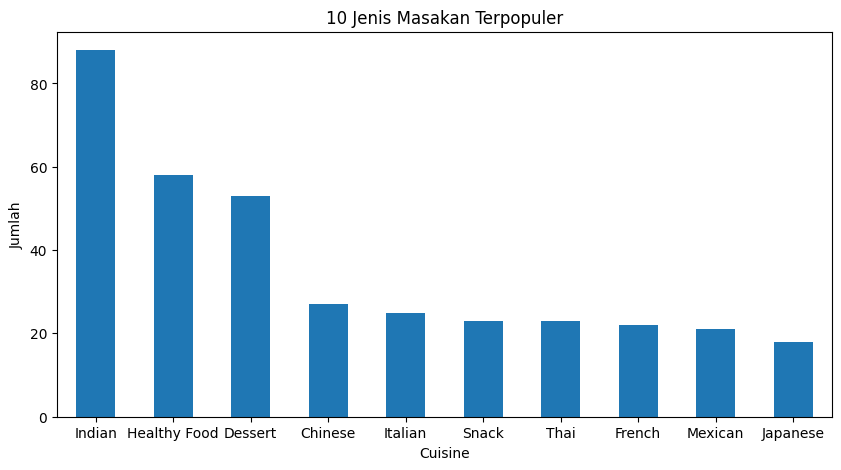

In [9]:
plt.figure(figsize=(10, 5))
food_df['C_Type'].value_counts().head(10).plot(kind='bar')
plt.title("10 Jenis Masakan Terpopuler")
plt.xlabel("Cuisine")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()

## Visualisasi distribusi rating
Visualisasi Ini Berguna Untuk Mengetahui Distribusi Rating

Hasil Visualisasi Menunjukkan Bahwa:
1. Rating 5 Paling Banyak, pengguna memberikan rating yang tinggi untuk makanan

2.  hanya sedikit makanan yang mendapatkan rating 1 & 2.

3. Distribusi Rating Condong ke kanan

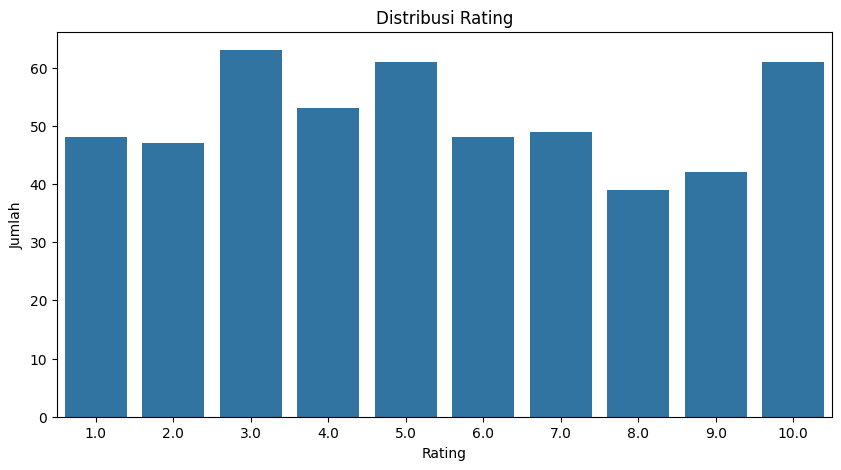

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Rating', data=ratings_df)
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

# 4. Preprocessing Data
Melakukan pembersihan dan normalisasi teks pada kolom deskripsi makanan. Kolom tersebut kemudian digabung untuk membuat representasi fitur yang akan digunakan dalam content-based filtering.

In [11]:
# Preprocessing teks: menghapus karakter non-alfabet, huruf kecil, dan stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Membersihkan kolom teks dan menggabungkan untuk ekstraksi fitur
for col in ['Name', 'C_Type', 'Veg_Non', 'Describe']:
    # Memastikan kolom ada di food_df sebelum membersihkan
    if col in food_df.columns:
        food_df[col] = food_df[col].fillna("").apply(clean_text)
    else:
        print(f"Warning: Column '{col}' not found in food_df.")


# Kolom gabungan yang akan digunakan untuk content-based filtering
food_df['combined'] = food_df['Name'] + " " + food_df['C_Type'] + " " + food_df['Veg_Non'] + " " + food_df['Describe']

# 5. Ekstraksi Fitur
TF-IDF digunakan untuk mengekstraksi fitur dari teks gabungan makanan, dan
cosine similarity digunakan untuk mengukur kemiripan antar makanan berdasarkan konten.

In [12]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(food_df['combined'])

similarity = cosine_similarity(tfidf_matrix)

# 6. Model Building
Melakukan pendekatan collaborative filtering menggunakan teknik matrix factorization melalui SVD, untuk memperkirakan preferensi pengguna terhadap makanan yang belum dirating.


In [13]:
# Mengubah data rating ke bentuk matrix (pivot)
user_item_matrix = ratings_df.pivot_table(index='User_ID', columns='Food_ID', values='Rating').fillna(0)

# Reduksi dimensi dengan TruncatedSVD untuk simulasi collaborative filtering
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

# Prediksi matrix rating (estimasi rating pengguna terhadap item)
predicted_ratings = np.dot(user_factors, item_factors.T)

# 7. Fungsi Rekomendasi Hybrid
Fungsi ini menggabungkan dua metode rekomendasi:

content-based dan collaborative filtering, untuk menghasilkan rekomendasi makanan terbaik.

In [23]:
def hybrid_recommendation(user_id, food_name, top_n=5, alpha=0.5):

    idx = food_df[food_df['Name'].str.lower() == food_name.lower()].index
    if len(idx) == 0:
        return f"Makanan '{food_name}' tidak ditemukan."
    idx = idx[0]

    # Ambil 50 item paling mirip secara konten
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_similar = [i[0] for i in sim_scores[1:50]]

    food_scores = []
    for i in top_similar:
        food_id = food_df.iloc[i]['Food_ID']
        if user_id in user_item_matrix.index and food_id in user_item_matrix.columns:
            est_rating = predicted_ratings[user_item_matrix.index.get_loc(user_id)][user_item_matrix.columns.get_loc(food_id)]
        else:
            est_rating = 0
        final_score = alpha * similarity[idx][i] + (1 - alpha) * est_rating
        food_scores.append((i, final_score))

    food_scores = sorted(food_scores, key=lambda x: x[1], reverse=True)
    recommended_idx = [i[0] for i in food_scores[:top_n]]
    return food_df['Name'].iloc[recommended_idx].tolist()

# 8. Contoh Penggunaan Rekomendasi
Menunjukkan contoh bagaimana fungsi rekomendasi digunakan untuk menghasilkan makanan rekomendasi berdasarkan input nama makanan dan user ID tertentu.


In [24]:
user_id = 1
makanan_input = 'rice'
hasil = hybrid_recommendation('User_ID', makanan_input, top_n=5)

print("Rekomendasi makanan (Hybrid):")

# Check if the result is a list of recommendations or a single string message
if isinstance(hasil, list):
    print("\n".join(hasil))
else:
    print(hasil)

Rekomendasi makanan (Hybrid):
red rice
black rice
brown rice
mushroom rice
rice kheer


# 9. Evaluasi
Fungsi `precision_recall_at_k` digunakan untuk menghitung `Precision@K` & `Recall@K` dari hasil rekomendasi. Metrik ini memberikan evaluasi numerik terhadap seberapa relevan rekomendasi yang diberikan dibanding preferensi pengguna.


In [26]:
def precision_recall_at_k(user_id, k=5):
    user_rated = ratings_df[ratings_df['User_ID'] == user_id].sort_values(by='Rating', ascending=False)
    top_rated_foods = user_rated['Food_ID'].tolist()[:k]

    if not top_rated_foods:
        return 0.0, 0.0

    # Find the name of the top rated food using food_df
    top_food_id = top_rated_foods[0]
    food_name_row = food_df[food_df['Food_ID'] == top_food_id]['Name']

    # Ensure food_name_row is not empty before accessing values
    if food_name_row.empty:
        return 0.0, 0.0 # Return 0 precision and recall if food name is not found

    top_food_name = food_name_row.values[0]

    # Pass the correct user_id (which is a number, not a string) and food_name to hybrid_recommendation
    recommended = hybrid_recommendation(user_id, top_food_name, top_n=k)

    # Mengganti 'df' dengan 'food_df' dan menggunakan nama kolom yang benar
    # Ensure recommended is a list before checking
    if isinstance(recommended, str): # If hybrid_recommendation returned an error string
        print(f"Warning: {recommended}")
        return 0.0, 0.0

    # Get the Food_IDs for the recommended food names
    recommended_ids = food_df[food_df['Name'].isin(recommended)]['Food_ID'].tolist()

    relevant_items = set(top_rated_foods)
    recommended_items = set(recommended_ids)

    # Handle cases where relevant_items might be empty
    if not relevant_items:
        return 1.0, 1.0 if not recommended_items else 0.0

    true_positives = relevant_items & recommended_items


    precision = len(true_positives) / k if k > 0 else 0.0
    recall = len(true_positives) / len(relevant_items) if len(relevant_items) > 0 else 0.0
    return precision, recall

# Contoh evaluasi untuk user 1
precision, recall = precision_recall_at_k(user_id=1, k=4)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.25
Recall: 0.25
